100%|██████████| 170M/170M [00:13<00:00, 13.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


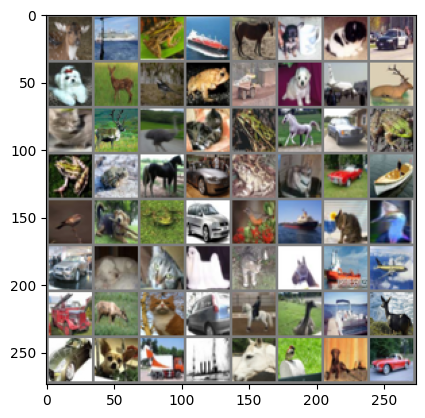

deer ship frog ship horse dog dog automobile


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Завантаження та нормалізація даних CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормалізація RGB
])

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Розділення навчальної вибірки на навчальну та валідаційну
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Створення DataLoader'ів
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Візуалізація прикладів з набору даних
classes = train_dataset.dataset.classes

def imshow(img):
    img = img / 2 + 0.5  # денормалізація
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]}" for j in range(8)))


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Перетворення в вектор
        x = F.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net = Net()
print(net)


Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [10]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [11]:
import torch.optim as optim

# Функція втрат
criterion = nn.CrossEntropyLoss()

# Оптимізатор
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)  # weight_decay для L2-регуляризації


In [12]:
from tqdm import tqdm

def train_model(net, train_loader, val_loader, num_epochs=50):
    train_losses, val_losses = [], []
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Нульова ініціалізація градієнтів
            optimizer.zero_grad()

            # Прямий прохід
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Валідація
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

        # Рання зупинка
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(net.state_dict(), "best_model.pth")

    return train_losses, val_losses

train_losses, val_losses = train_model(net, train_loader, val_loader)


Epoch 1/50: 100%|██████████| 625/625 [00:13<00:00, 45.70it/s]


Epoch 1: Train Loss = 1.8169, Val Loss = 1.6550


Epoch 2/50: 100%|██████████| 625/625 [00:14<00:00, 44.31it/s]


Epoch 2: Train Loss = 1.6897, Val Loss = 1.5690


Epoch 3/50: 100%|██████████| 625/625 [00:13<00:00, 47.96it/s]


Epoch 3: Train Loss = 1.6631, Val Loss = 1.5336


Epoch 4/50: 100%|██████████| 625/625 [00:12<00:00, 48.29it/s]


Epoch 4: Train Loss = 1.6464, Val Loss = 1.5412


Epoch 5/50: 100%|██████████| 625/625 [00:15<00:00, 40.29it/s]


Epoch 5: Train Loss = 1.6355, Val Loss = 1.5116


Epoch 6/50: 100%|██████████| 625/625 [00:13<00:00, 46.73it/s]


Epoch 6: Train Loss = 1.6273, Val Loss = 1.5217


Epoch 7/50: 100%|██████████| 625/625 [00:13<00:00, 46.39it/s]


Epoch 7: Train Loss = 1.6324, Val Loss = 1.5048


Epoch 8/50: 100%|██████████| 625/625 [00:13<00:00, 46.90it/s]


Epoch 8: Train Loss = 1.6246, Val Loss = 1.5023


Epoch 9/50: 100%|██████████| 625/625 [00:13<00:00, 47.35it/s]


Epoch 9: Train Loss = 1.6234, Val Loss = 1.5290


Epoch 10/50: 100%|██████████| 625/625 [00:13<00:00, 45.68it/s]


Epoch 10: Train Loss = 1.6228, Val Loss = 1.5136


Epoch 11/50: 100%|██████████| 625/625 [00:13<00:00, 47.30it/s]


Epoch 11: Train Loss = 1.6156, Val Loss = 1.5128


Epoch 12/50: 100%|██████████| 625/625 [00:13<00:00, 46.65it/s]


Epoch 12: Train Loss = 1.6136, Val Loss = 1.4942


Epoch 13/50: 100%|██████████| 625/625 [00:13<00:00, 47.71it/s]


Epoch 13: Train Loss = 1.6203, Val Loss = 1.5044


Epoch 14/50: 100%|██████████| 625/625 [00:13<00:00, 47.49it/s]


Epoch 14: Train Loss = 1.6161, Val Loss = 1.5041


Epoch 15/50: 100%|██████████| 625/625 [00:13<00:00, 46.30it/s]


Epoch 15: Train Loss = 1.6121, Val Loss = 1.4927


Epoch 16/50: 100%|██████████| 625/625 [00:13<00:00, 44.81it/s]


Epoch 16: Train Loss = 1.6143, Val Loss = 1.4871


Epoch 17/50: 100%|██████████| 625/625 [00:13<00:00, 47.48it/s]


Epoch 17: Train Loss = 1.6051, Val Loss = 1.4858


Epoch 18/50: 100%|██████████| 625/625 [00:13<00:00, 47.39it/s]


Epoch 18: Train Loss = 1.6148, Val Loss = 1.4825


Epoch 19/50: 100%|██████████| 625/625 [00:13<00:00, 47.36it/s]


Epoch 19: Train Loss = 1.6101, Val Loss = 1.5067


Epoch 20/50: 100%|██████████| 625/625 [00:13<00:00, 47.53it/s]


Epoch 20: Train Loss = 1.6067, Val Loss = 1.4919


Epoch 21/50: 100%|██████████| 625/625 [00:13<00:00, 47.46it/s]


Epoch 21: Train Loss = 1.6071, Val Loss = 1.5021


Epoch 22/50: 100%|██████████| 625/625 [00:13<00:00, 45.82it/s]


Epoch 22: Train Loss = 1.6066, Val Loss = 1.4781


Epoch 23/50: 100%|██████████| 625/625 [00:13<00:00, 46.61it/s]


Epoch 23: Train Loss = 1.6121, Val Loss = 1.5039


Epoch 24/50: 100%|██████████| 625/625 [00:14<00:00, 43.99it/s]


Epoch 24: Train Loss = 1.6067, Val Loss = 1.4810


Epoch 25/50: 100%|██████████| 625/625 [00:13<00:00, 47.05it/s]


Epoch 25: Train Loss = 1.6048, Val Loss = 1.5030


Epoch 26/50: 100%|██████████| 625/625 [00:13<00:00, 47.18it/s]


Epoch 26: Train Loss = 1.6107, Val Loss = 1.4845


Epoch 27/50: 100%|██████████| 625/625 [00:13<00:00, 47.89it/s]


Epoch 27: Train Loss = 1.6114, Val Loss = 1.5028


Epoch 28/50: 100%|██████████| 625/625 [00:13<00:00, 47.38it/s]


Epoch 28: Train Loss = 1.6085, Val Loss = 1.4939


Epoch 29/50: 100%|██████████| 625/625 [00:13<00:00, 46.80it/s]


Epoch 29: Train Loss = 1.6024, Val Loss = 1.4882


Epoch 30/50: 100%|██████████| 625/625 [00:13<00:00, 46.83it/s]


Epoch 30: Train Loss = 1.6022, Val Loss = 1.4904


Epoch 31/50: 100%|██████████| 625/625 [00:13<00:00, 47.17it/s]


Epoch 31: Train Loss = 1.6069, Val Loss = 1.4853


Epoch 32/50: 100%|██████████| 625/625 [00:13<00:00, 47.10it/s]


Epoch 32: Train Loss = 1.6049, Val Loss = 1.4934


Epoch 33/50: 100%|██████████| 625/625 [00:13<00:00, 47.35it/s]


Epoch 33: Train Loss = 1.6072, Val Loss = 1.4850


Epoch 34/50: 100%|██████████| 625/625 [00:13<00:00, 46.59it/s]


Epoch 34: Train Loss = 1.6069, Val Loss = 1.4867


Epoch 35/50: 100%|██████████| 625/625 [00:13<00:00, 47.00it/s]


Epoch 35: Train Loss = 1.6080, Val Loss = 1.4691


Epoch 36/50: 100%|██████████| 625/625 [00:13<00:00, 45.75it/s]


Epoch 36: Train Loss = 1.6032, Val Loss = 1.4841


Epoch 37/50: 100%|██████████| 625/625 [00:13<00:00, 47.16it/s]


Epoch 37: Train Loss = 1.6044, Val Loss = 1.4770


Epoch 38/50: 100%|██████████| 625/625 [00:13<00:00, 46.79it/s]


Epoch 38: Train Loss = 1.5990, Val Loss = 1.4727


Epoch 39/50: 100%|██████████| 625/625 [00:13<00:00, 47.22it/s]


Epoch 39: Train Loss = 1.6060, Val Loss = 1.4904


Epoch 40/50: 100%|██████████| 625/625 [00:13<00:00, 47.50it/s]


Epoch 40: Train Loss = 1.6061, Val Loss = 1.4791


Epoch 41/50: 100%|██████████| 625/625 [00:13<00:00, 47.27it/s]


Epoch 41: Train Loss = 1.6050, Val Loss = 1.4893


Epoch 42/50: 100%|██████████| 625/625 [00:13<00:00, 47.10it/s]


Epoch 42: Train Loss = 1.6084, Val Loss = 1.4810


Epoch 43/50: 100%|██████████| 625/625 [00:13<00:00, 46.18it/s]


Epoch 43: Train Loss = 1.6021, Val Loss = 1.4763


Epoch 44/50: 100%|██████████| 625/625 [00:13<00:00, 46.91it/s]


Epoch 44: Train Loss = 1.6031, Val Loss = 1.4809


Epoch 45/50: 100%|██████████| 625/625 [00:13<00:00, 47.18it/s]


Epoch 45: Train Loss = 1.6070, Val Loss = 1.4842


Epoch 46/50: 100%|██████████| 625/625 [00:13<00:00, 47.19it/s]


Epoch 46: Train Loss = 1.6069, Val Loss = 1.4898


Epoch 47/50: 100%|██████████| 625/625 [00:13<00:00, 47.56it/s]


Epoch 47: Train Loss = 1.6060, Val Loss = 1.4766


Epoch 48/50: 100%|██████████| 625/625 [00:13<00:00, 47.10it/s]


Epoch 48: Train Loss = 1.6056, Val Loss = 1.4816


Epoch 49/50: 100%|██████████| 625/625 [00:13<00:00, 47.31it/s]


Epoch 49: Train Loss = 1.6097, Val Loss = 1.4856


Epoch 50/50: 100%|██████████| 625/625 [00:13<00:00, 46.75it/s]


Epoch 50: Train Loss = 1.6078, Val Loss = 1.4933


In [15]:
# Завантаження найкращої моделі
net.load_state_dict(torch.load("best_model.pth"))

# Оцінка на тестових даних
net.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")


<ipython-input-15-63112b6df272>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("best_model.pth"))


Test Loss: 1.4665, Test Accuracy: 49.02%


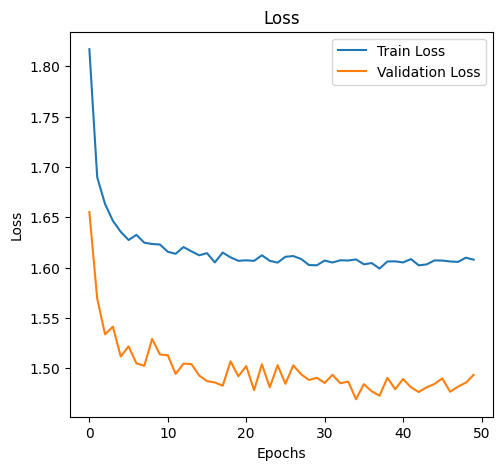

In [16]:
# Графіки втрат
plt.figure(figsize=(12, 5))

# Графік втрат
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()
